<a href="https://colab.research.google.com/github/AkshitAggarwal/TSAI_EVA5B2_Phase1/blob/main/Session_07/S7_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries



In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy

In [2]:
train_transforms = transforms.Compose([
                                    #   transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                      ])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                    ])

In [3]:
train_dataset = datasets.CIFAR10(root='./data', train = True, transform = train_transforms, download = True)
test_dataset = datasets.CIFAR10(root='./data', train = False, transform = test_transforms, download = True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu") #Assigns device based on availability

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#Arguments to be fed into dataloaders. 
dataloader_args = dict(shuffle=True, batch_size=100, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

##Train and Test dataloaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [5]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([100, 3, 32, 32])


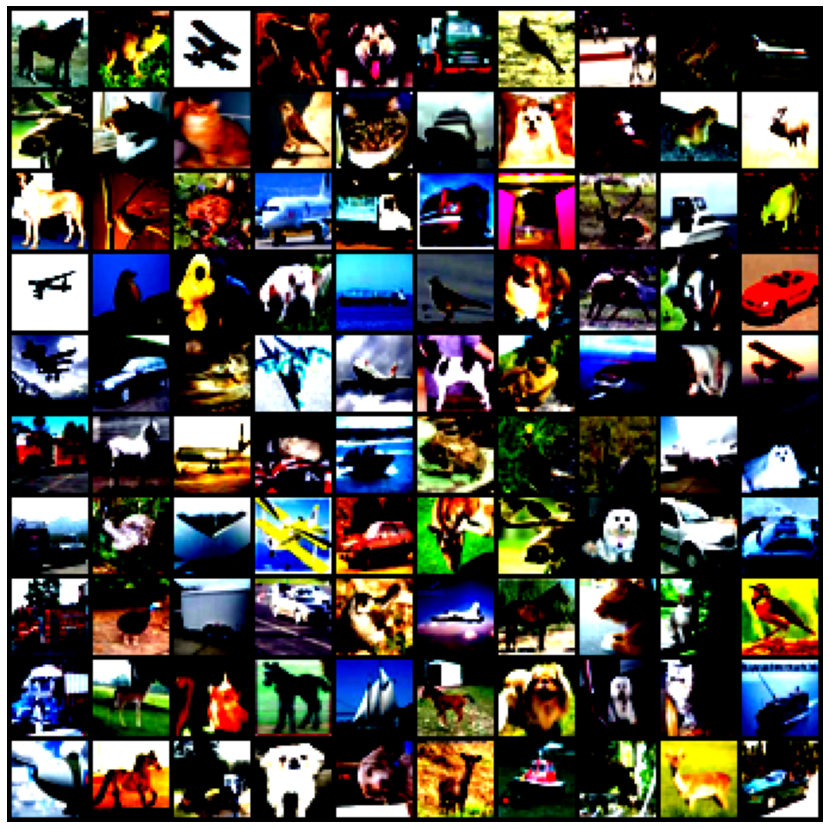

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(utils.make_grid(images, nrow=10).permute((1, 2, 0)))
    break

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device) #Converts our model into the respective device.
summary(model, input_size=(3, 32, 32)) #Prints the summary of our model based on an input size.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.cross_entropy(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    description = 'Loss={:.4f} Batch_id={} Accuracy={:.2f}'.format(loss.item(), batch_idx, 100*correct/processed)
    train_acc.append(100*correct/processed)
  print(description)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for d, t, p in zip(data, target, pred):
              if len(misclassified) < 25:
                if p != t:
                  misclassified.append((d, t, p))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss, 100. * correct / len(test_loader.dataset), misclassified

In [12]:
def train_test_model(model, epochs = 25):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #Learning Rate schedular to adjust the LR based on model performance during training
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)
    epoch_accuracies = []
    epoch_losses = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        train(model, device, train_loader, optimizer, epoch)
        loss, accuracy, misclassified = test(model, device, test_loader)
        scheduler.step(loss)
        epoch_accuracies.append(accuracy)
        epoch_losses.append(loss)
    return epoch_losses, epoch_accuracies, misclassified 

In [13]:
models =  [Net().to(device)]
EPOCHS = 25

model_accuracies = [] #Accuracies over different models
model_losses = [] #Losses over different models
all_misclassified = []

for model in models:
    # print('============== Model: ', label, '===================')
    loss, accuracy, misclassified = train_test_model(model, epochs = EPOCHS)
    model_losses.append(loss)
    model_accuracies.append(accuracy)
    all_misclassified.append(misclassified)

EPOCH: 0
Learning rate:  0.001
Loss=2.2246 Batch_id=499 Accuracy=12.46

Test set: Average loss: 2.2282, Accuracy: 2067/10000 (20.67%)

EPOCH: 1
Learning rate:  0.001
Loss=2.0191 Batch_id=499 Accuracy=25.46

Test set: Average loss: 1.9751, Accuracy: 2932/10000 (29.32%)

EPOCH: 2
Learning rate:  0.001
Loss=1.9342 Batch_id=499 Accuracy=31.91

Test set: Average loss: 1.8205, Accuracy: 3471/10000 (34.71%)

EPOCH: 3
Learning rate:  0.001
Loss=1.7206 Batch_id=499 Accuracy=37.06

Test set: Average loss: 1.6562, Accuracy: 4001/10000 (40.01%)

EPOCH: 4
Learning rate:  0.001
Loss=1.5671 Batch_id=499 Accuracy=40.82

Test set: Average loss: 1.5755, Accuracy: 4307/10000 (43.07%)

EPOCH: 5
Learning rate:  0.001
Loss=1.5343 Batch_id=499 Accuracy=43.30

Test set: Average loss: 1.5322, Accuracy: 4439/10000 (44.39%)

EPOCH: 6
Learning rate:  0.001
Loss=1.7398 Batch_id=499 Accuracy=45.37

Test set: Average loss: 1.4780, Accuracy: 4629/10000 (46.29%)

EPOCH: 7
Learning rate:  0.001
Loss=1.4544 Batch_id=499

In [14]:
labels = ['Cifar10_toy_Model']

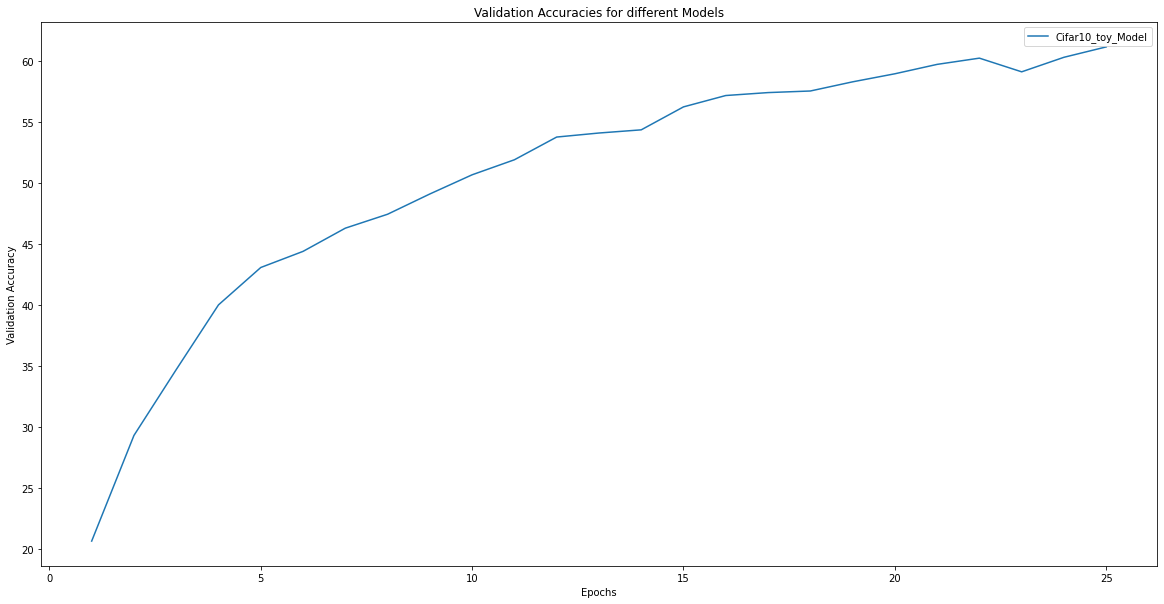

In [15]:
x = [t+1 for t in range(EPOCHS)]
plt.figure(figsize=(20,10))
for accuracy, label in zip(model_accuracies, labels):
  plt.plot(x, accuracy, label = label)
plt.xlabel('Epochs') #Sets label for X-axis
plt.ylabel('Validation Accuracy') #Sets label for Y-axis
plt.title('Validation Accuracies for different Models') #Sets label for the plot
plt.legend() #Shows the legend for the plot
plt.show()

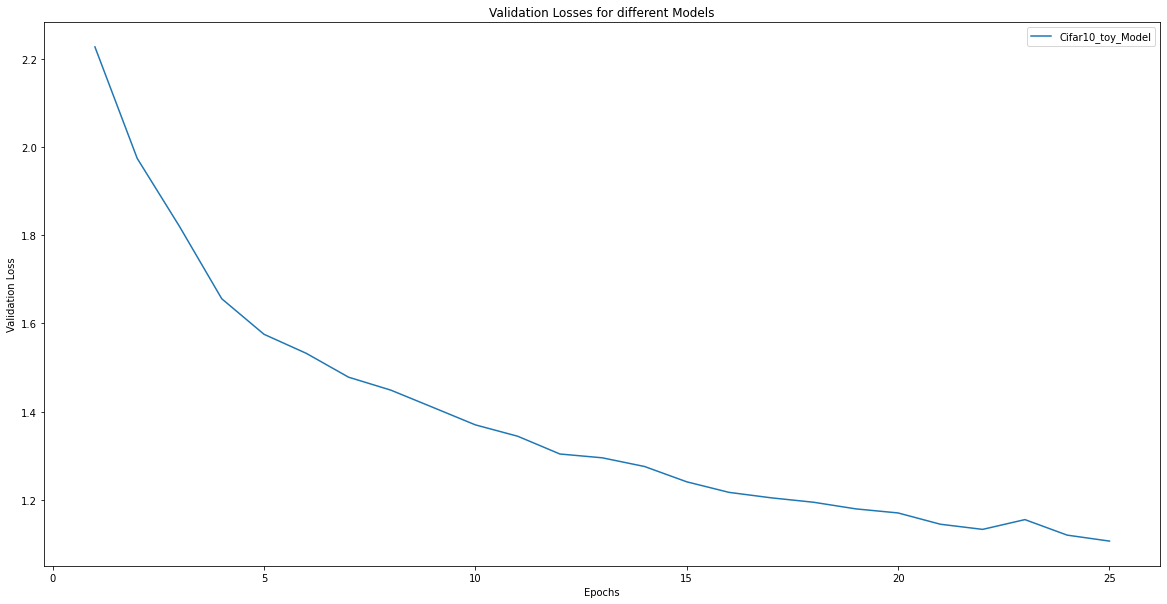

In [16]:
x = [t+1 for t in range(EPOCHS)]
plt.figure(figsize=(20,10))
for loss, label in zip(model_losses, labels):
  plt.plot(x, loss, label = label)
plt.xlabel('Epochs') #Sets label for X-axis
plt.ylabel('Validation Loss') #Sets label for Y-axis
plt.title('Validation Losses for different Models') #Sets label for the plot
plt.legend() #Shows the legend for the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

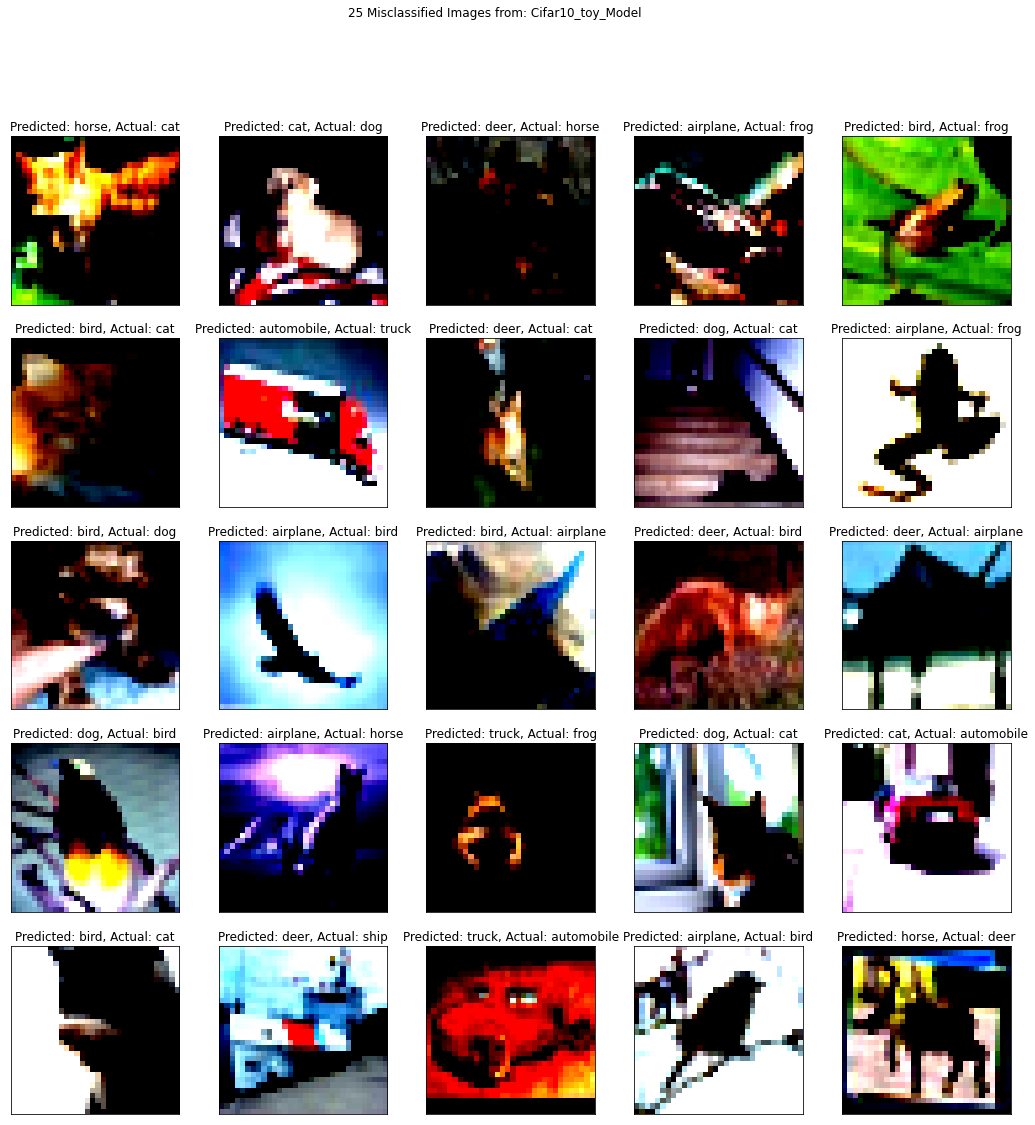

In [22]:
image_idx = []


plt.figure(figsize=(18,18))
missed  = all_misclassified[0]
plt.suptitle('25 Misclassified Images from: ' + labels[0])
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Predicted: {}, Actual: {}'.format(str(classes[missed[i][2].item()]), classes[missed[i][1].item()]))
    plt.imshow(missed[i][0].cpu().permute((1, 2, 0)))

plt.show()